In [11]:
import torch
import torch.nn as nn 
import os 
import numpy as np 
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torchaudio.models.decoder import ctc_decoder
from matplotlib import pyplot as plt

**credits**: The following code is heavily inspired by 
- https://github.com/cmudeeplearning11785/Fall2018-tutorials/blob/master/recitation-8/ctc_handwritten_digit_reader.ipynb
- https://github.com/pythonlessons/mltu/blob/main/Tutorials/08_handwriting_recognition_torch/model.py

### generate and load data

In [2]:
# check if data already exists and synthesize if not
if not os.path.exists("dataset") or (os.listdir("dataset")) == 0:
    import src.data.mkSeqMNIST as data_synthesizer
    data_synthesizer.make()

# loading the dataset 
data, labels = np.load("dataset/data.npy"), np.load("dataset/labels.npy")

print("Data shape:", data.shape) 
print("(num_samples, height, width)\n")
print("Labels shape: ", labels.shape) 


Data shape: (20000, 36, 172)
(num_samples, height, width)

Labels shape:  (20000, 10)


### model architecture

In [3]:
class CNNLSTM(nn.Module):
    def __init__(self):
        super(CNNLSTM, self).__init__() 
        self.embed = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=(2, 1), padding=(1, 1), bias=False),
            nn.ELU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=(1, 1), padding=(1, 1), bias=False),
            nn.ELU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=(2, 2), padding=(1, 1), bias=False),
            nn.ELU(),
            nn.Conv2d(64, 32, kernel_size=3, stride=(1, 1), padding=(1, 1), bias=False),
            nn.ELU()
        )
        dim = 288
        hidden_size = 256
        self.lstm = nn.LSTM(input_size=dim, hidden_size=hidden_size)
        self.output_layer = nn.Linear(in_features=hidden_size, out_features=10 + 1)

    def forward(self, features):
        # features: n, 1, h, w
        embedding = self.embed(features)
        n, c, h, w = embedding.size() 
        embedding = embedding.view(n, c*h, w).permute(2, 0, 1)
        # embed: t, n, f
        h, _ = self.lstm(embedding)
        logits = self.output_layer(h)
        
        log_probs = torch.nn.functional.log_softmax(logits, dim=2)
        return log_probs    

### constants 

In [71]:
# train/test split
split = 0.8
batch_size = 32
max_epochs = 1000 
blank = 10 

### data preprocessing

In [50]:

split_idx = int(split*len(data))

train_set = TensorDataset(
    torch.tensor(data[:split_idx], dtype=torch.float32),
    torch.tensor(labels[:split_idx], dtype=torch.long)
)

test_set = TensorDataset(
    torch.tensor(data[split_idx:], dtype=torch.float32),
    torch.tensor(labels[split_idx:], dtype=torch.long)
)

loader = DataLoader(train_set, shuffle=True, batch_size=batch_size)

### model training

In [63]:
model = CNNLSTM() 
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) 
criterion = torch.nn.CTCLoss(blank=10) 

In [64]:
for i in range(max_epochs):
    image, label = next(iter(loader))
    image = image.unsqueeze(1) # (b, 1, h, w) 
    
    
    if i == 0:
        print("image shape:", image.shape) 
        print("label shape:", label.shape) 

    optimizer.zero_grad()
    log_probs = model(image)
    
    if i == 0:
        print("log_probs shape:", log_probs.shape)
        
    input_lengths = torch.full((batch_size,), log_probs.size(0), dtype=torch.long)
    target_lengths = torch.full((batch_size,), label.size(1), dtype=torch.long) 
    
    loss = criterion(log_probs, label, input_lengths, target_lengths)
    loss.backward()
    if i % 10 == 0:
        print("Loss:", loss.item())
    optimizer.step()
    
    
    

image shape: torch.Size([32, 1, 36, 172])
label shape: torch.Size([32, 10])
log_probs shape: torch.Size([86, 32, 11])
Loss: 15.341656684875488
Loss: 2.742492198944092
Loss: 2.5265560150146484
Loss: 2.500366449356079
Loss: 2.4946186542510986
Loss: 2.4943463802337646
Loss: 2.4750099182128906
Loss: 2.4954755306243896
Loss: 2.483037233352661
Loss: 2.4588990211486816
Loss: 2.4608964920043945
Loss: 2.4439175128936768
Loss: 2.4782049655914307
Loss: 2.441493034362793
Loss: 2.444845199584961
Loss: 2.4394919872283936
Loss: 2.3947553634643555
Loss: 2.411414623260498
Loss: 2.420473337173462
Loss: 2.3931427001953125
Loss: 2.3718042373657227
Loss: 2.3491389751434326
Loss: 2.2824559211730957
Loss: 2.2762248516082764
Loss: 2.2504615783691406
Loss: 2.275609016418457
Loss: 2.1494109630584717
Loss: 2.139604091644287
Loss: 2.0986745357513428
Loss: 1.9940836429595947
Loss: 1.8624815940856934
Loss: 1.6873948574066162
Loss: 1.6617395877838135
Loss: 1.4163826704025269
Loss: 1.2862708568572998
Loss: 1.23187434

In [69]:
def greedy_decode(log_probs, blank_index):
    """
    Decode using greedy method.
    :param log_probs: Log probabilities from the model (T x V)
    :param blank_index: Index of the blank token
    :return: Decoded sequence as a string
    """
    max_indices = np.argmax(log_probs, axis=1)  # Argmax over vocabulary
    sequence = ""
    previous = None
    vocab = [ "0", "1", "2", "3", "4", "5", "6", "7", "8", "9",""] 
    
    for index in max_indices:
        if index != previous:  # Skip consecutive duplicates
            if index != blank_index:  # Skip blank tokens
                sequence += vocab[index]
        previous = index

    return sequence

Predicted text: 8470894784


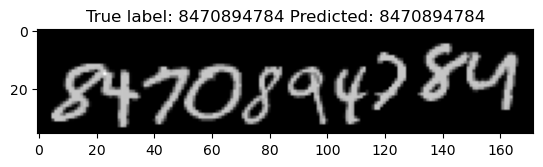

Predicted text: 7952427719


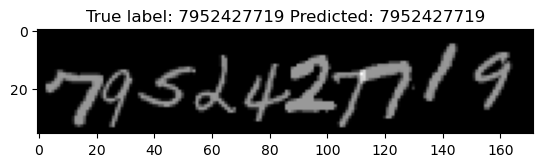

Predicted text: 3266476868


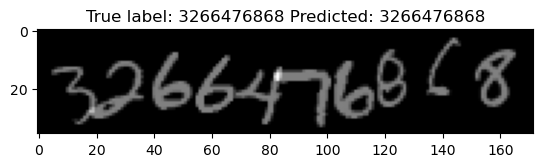

Predicted text: 38137402283


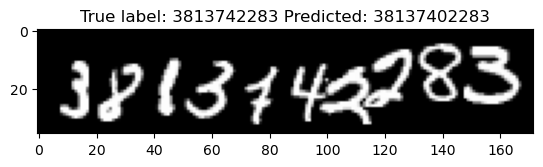

Predicted text: 3870222347


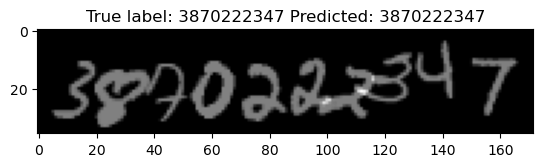

In [72]:
for i in range(5): 
    image = test_set[i][0]
    label = test_set[i][1]
    
    label_str = "".join([str(i) for i in label.numpy() ])  
    plt.imshow(image.squeeze(), cmap="gray")
    
    
    predicted = model(image.unsqueeze(0).unsqueeze(0)).detach() # (1, 1, h, w)
    predicted_text = greedy_decode(predicted.squeeze().detach().numpy(), blank)
    print("Predicted text:", predicted_text)
    plt.title("True label: " + label_str + " Predicted: " + predicted_text)
    plt.show()
    